# **Project Title : . HR Analytics - Predict Employee Attrition**

# Contribution = Apurba Kuiti

# **Project Summary**

# Objective:
To analyze employee data and identify key factors influencing attrition (resignation) using Machine Learning models — Logistic Regression and Decision Tree — and explain the predictions using SHAP values.

# Tools Used:
Python (Pandas, Seaborn, Sklearn, Matplotlib), Power BI (for visualization), SHAP (for model interpretation).

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/HR_Employee_Attrition.csv'
df = pd.read_csv(file_path)

# **Dataset loading and first check**

# **Goal: Is there any null in any column, is there any duplicate, what are the column names.**

In [ ]:
print(df.shape)
display(df.head())
df.info()
df.isnull().sum()
df.duplicated().sum()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

np.int64(0)

# **Target and some new features:-**

# 1.   **Attrition convert binary: yes->1, no->0**
# 2.   **Income-band, term-group creation**

In [ ]:
df['Attrition_flag'] = df['Attrition'].map({'Yes':1,'No':0})

# income quartile
df['IncomeBand'] = pd.qcut(df['MonthlyIncome'], 4, labels=['Low','Mid','High','Very High'])

# tenure group
df['TenureGroup'] = pd.cut(df['YearsAtCompany'], bins=[-1,1,3,5,10,50], labels=['<1','1-3','3-5','5-10','10+'])

# EDA Part

Attrition rate: 16.12%


Text(0, 0.5, 'Attrition rate')

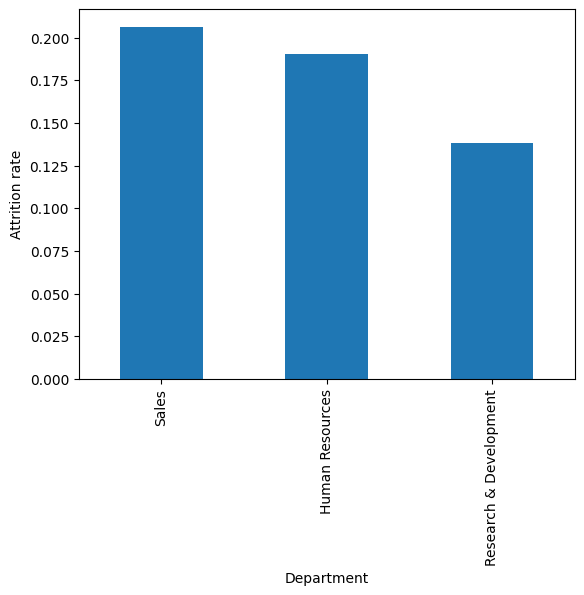

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# overall rate
rate = df['Attrition_flag'].mean()
print(f'Attrition rate: {rate:.2%}')

# dept-wise rate
dept = df.groupby('Department')['Attrition_flag'].mean().sort_values(ascending=False)
dept.plot(kind='bar')
plt.ylabel('Attrition rate')

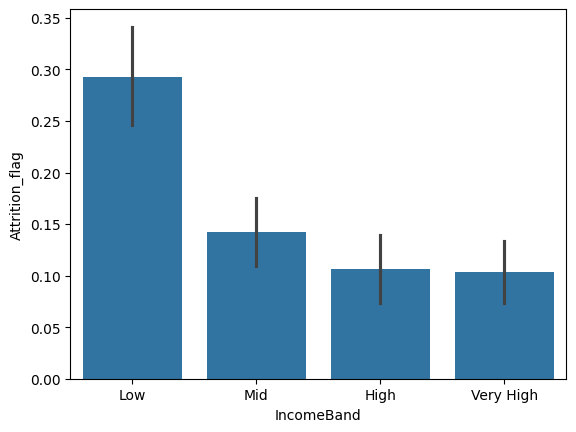

In [ ]:
# income band vs attrition
sns.barplot(x='IncomeBand', y='Attrition_flag', data=df)
plt.show()

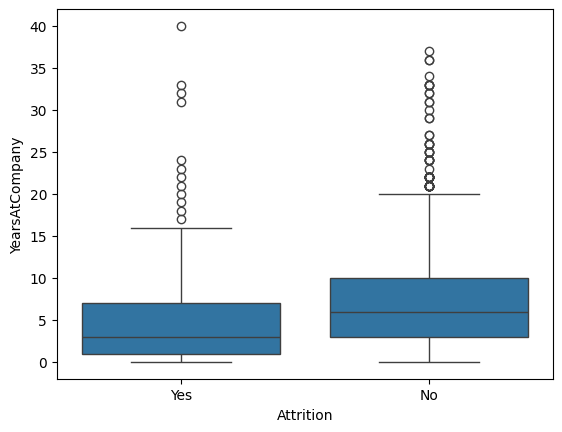

In [ ]:
# years at company by attrition
sns.boxplot(x='Attrition', y='YearsAtCompany', data=df)
plt.show()

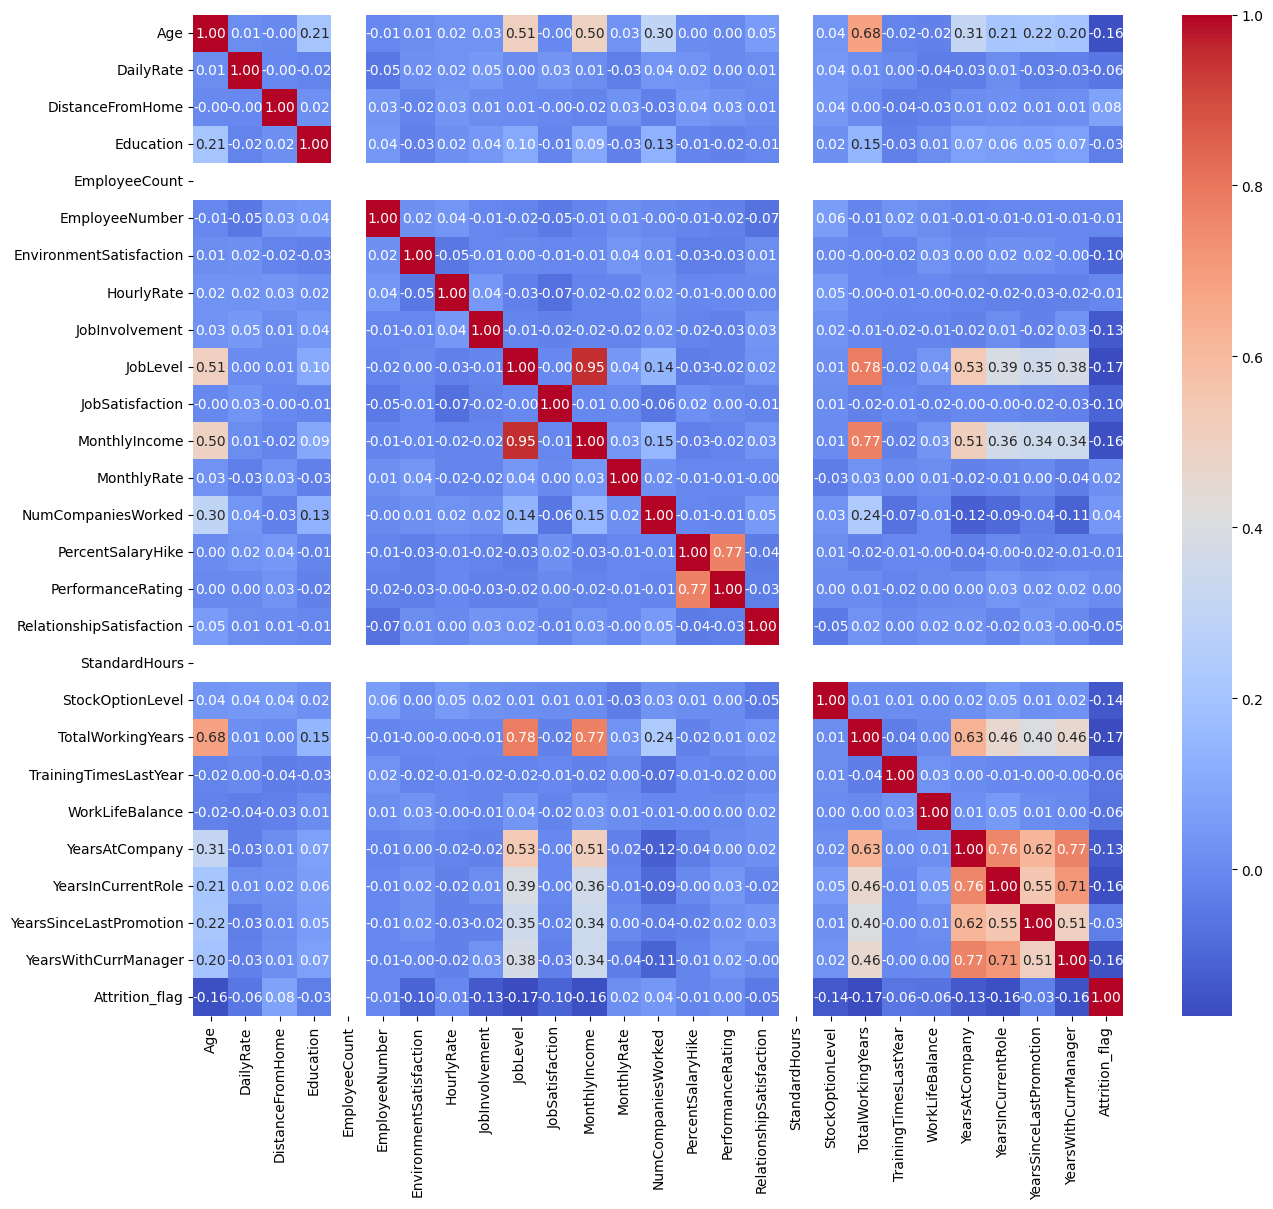

In [ ]:
# correlation heatmap
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(15,13))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

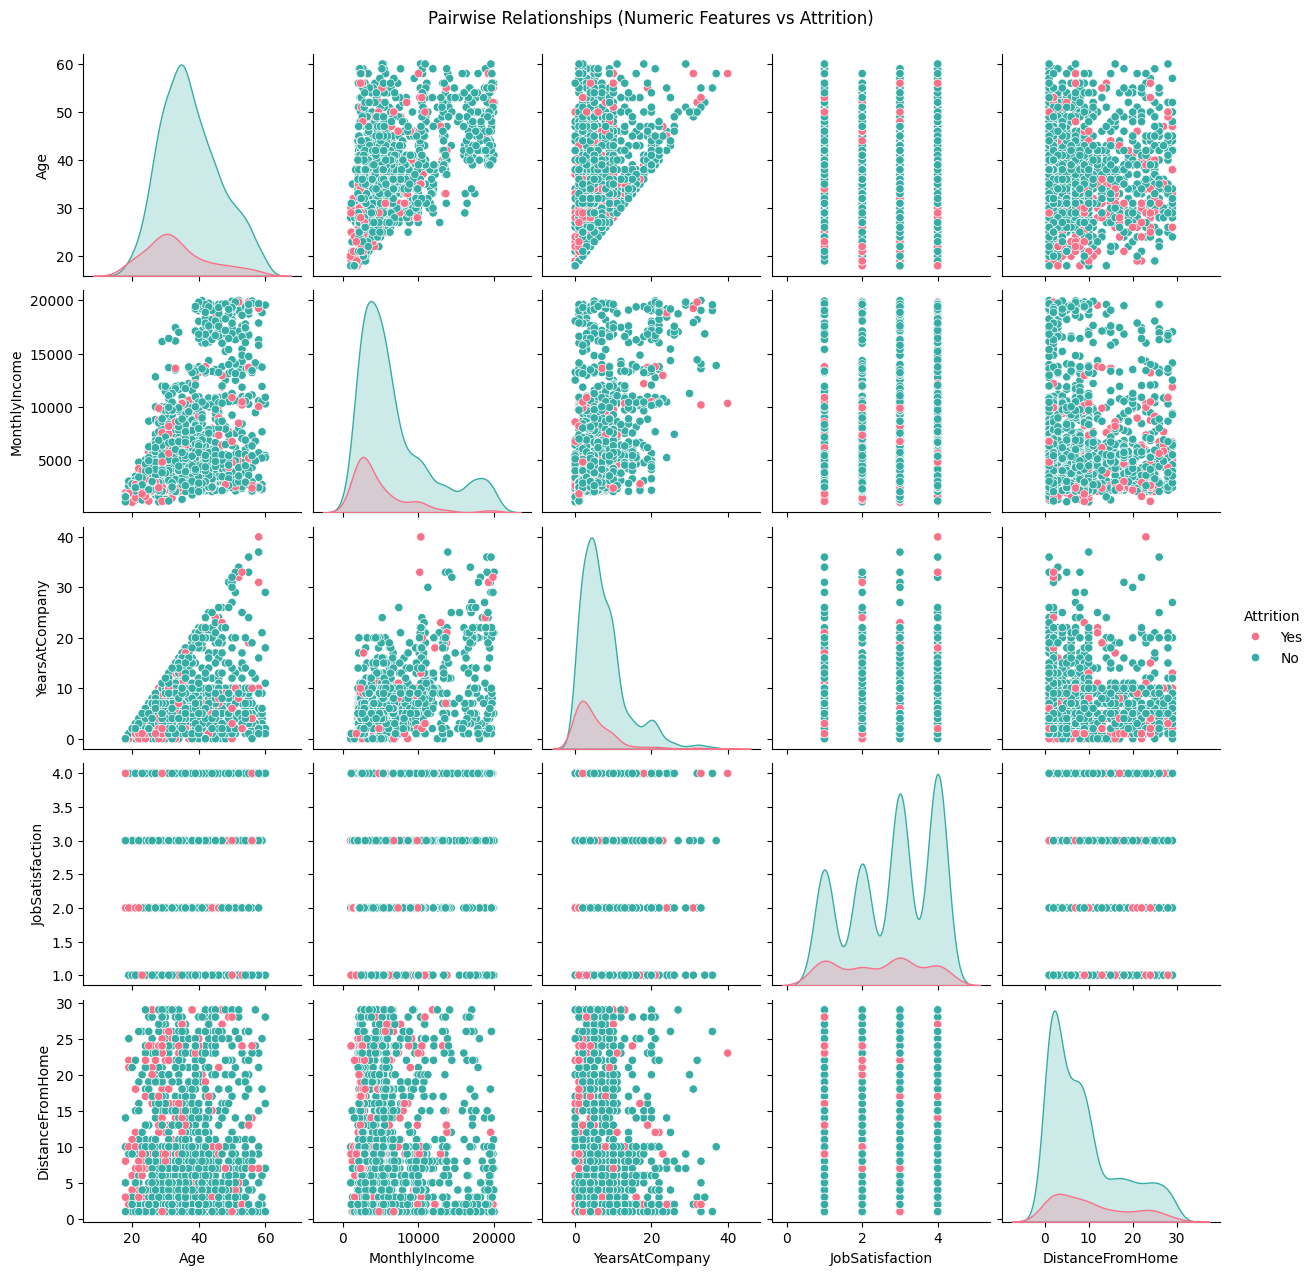

In [ ]:
# Choose key numeric columns
num_cols = ['Age','MonthlyIncome','YearsAtCompany','JobSatisfaction','DistanceFromHome']

# Pairplot for numeric features vs Attrition
sns.pairplot(df, vars=num_cols, hue='Attrition', diag_kind='kde', palette='husl')
plt.suptitle('Pairwise Relationships (Numeric Features vs Attrition)', y=1.02)
plt.show()

# Categorical (one-hot or label encode) encoding and feature prep

In [ ]:
# separate X, y
y = df['Attrition_flag']
X = df.drop(columns=['Attrition','Attrition_flag'], errors='ignore')

# categorical -> get_dummies
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# example: fill remaining missing and scale numeric
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=['int64','float64']).columns
imp = SimpleImputer(strategy='median')
X[num_cols] = imp.fit_transform(X[num_cols])

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/Test split and baseline model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Modeling — Logistic Regression and Decision Tree

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import r2_score

# logistic
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print('ROC AUC:', roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

# decision tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))
print('ROC AUC:', roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

# R2 Score
r2_lr = r2_score(y_test, y_pred_lr)
r2_dt = r2_score(y_test, y_pred_dt)

print("\nR2 Score (Logistic Regression):", r2_lr)
print("R2 Score (Decision Tree):", r2_dt)


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.74      0.36      0.49        47

    accuracy                           0.88       294
   macro avg       0.81      0.67      0.71       294
weighted avg       0.87      0.88      0.86       294

ROC AUC: 0.8284951330863984
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.47      0.17      0.25        47

    accuracy                           0.84       294
   macro avg       0.66      0.57      0.58       294
weighted avg       0.80      0.84      0.80       294

ROC AUC: 0.6605220087862865

R2 Score (Logistic Regression): 0.08829356533723842
R2 Score (Decision Tree): -0.21560857955034884


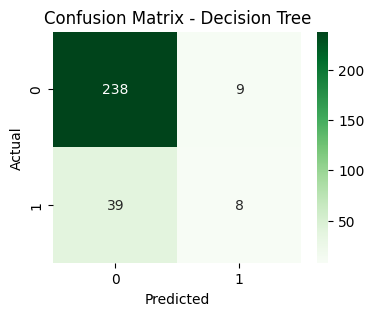

In [ ]:
# Confusion Matrix

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(4,3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Insight:

Model predicts most “non-attrition” cases correctly.

But only 8 out of 47 attrition cases were identified (recall for attrition = 0.17).

Indicates the model is conservative — it avoids false positives but misses many true attritions.

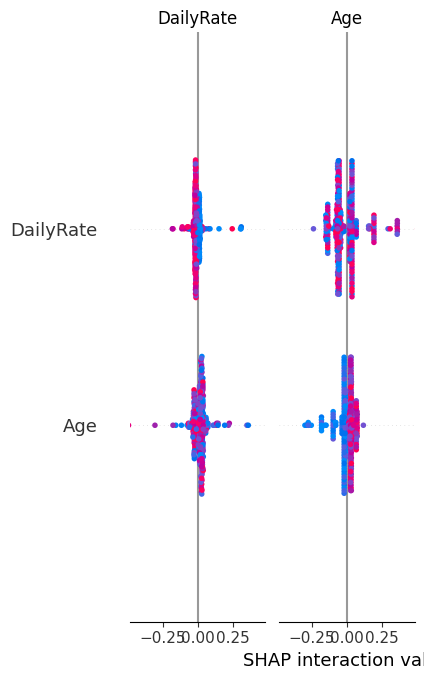

In [ ]:
import shap

# Convert boolean columns to integers
X_test_numeric = X_test.copy()
for col in X_test_numeric.columns:
    if X_test_numeric[col].dtype == 'bool':
        X_test_numeric[col] = X_test_numeric[col].astype(int)


# Use the model with predict_proba (Logistic Regression or Decision Tree)
explainer = shap.Explainer(dt, X_test_numeric)  # or lr
shap_values = explainer(X_test_numeric)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_test_numeric)

# **SHAP Value Analysis (Explainability)**
Graph Insight (DailyRate vs Age)

SHAP interaction plot shows how DailyRate and Age interact to affect attrition prediction.

Points in pink/red represent higher feature values, blue are lower.

Symmetry around 0 means neither feature strongly dominates prediction individually — they interact modestly.

Employees with lower DailyRate or younger Age slightly contribute to higher attrition probability.

Interpretation:
SHAP helps identify subtle, data-driven relationships that the raw coefficients or feature importances might not show.

# 4. Key Findings

Major Predictors: Age, DailyRate, JobSatisfaction, Promotion status, and WorkLifeBalance.

High-risk groups:

Younger employees with lower salaries or fewer promotions.

Employees with longer tenure but stagnant positions.

Retention Strategies:

Introduce salary reviews for low pay bands.

Create mentorship or promotion programs.

Offer flexible working options to balance stress.